<a href="https://colab.research.google.com/github/Kalyankr/Numerical-ml-models/blob/master/Telecom_Custmer_Churn_Vartional_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An autoencoder is deep learning’s answer to dimensionality reduction. The idea is pretty simple: transform the input through a series of hidden layers but ensure that the final output layer is the same dimension as the input layer. However, the intervening hidden layers have progressively smaller number of nodes (and hence, reduce the dimension of the input matrix). If the output matches or encodes the input closely, then the nodes of the smallest hidden layer can be taken as a valid dimension reduced data set.

A variational autoencoder (VAE) resembles a classical autoencoder and is a neural network consisting of an encoder, a decoder and a loss function. They let us design complex generative models of data, and fit them to large data sets.

After reading an article on using convolutional networks and autoencoders to provide insights into user churn [ https://www.vidora.com/the-state-of-ml/can-neural-networks-provide-insight-into-user-churn/ ]. I decided to implement VAE to a telecom churn data set that can be downloaded from IBM Sample Data Sets. It is a bit of overkill to apply VAE to a relative small data set like this, but for the sake of learning VAE, I am going to do.

In [0]:
#!wget  https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv?cm_mc_uid=26872494981215462371246&cm_mc_sid_50200000=63643931556650143404&cm_mc_sid_52640000=23092111556650143407

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.callbacks import Callback
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)



Using TensorFlow backend.


In [0]:
data=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

   
1.   Customers who left within the last month — the column is called Churn

2.   Services that each customer has signed up for — phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

3. Customer account information — how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
4.     Demographic info about customers — gender, age range, and if they have partners and dependents.


  

In [0]:
# total charges are number but it is object type in dataset so convert into numberic

data["TotalCharges"]=pd.to_numeric(data["TotalCharges"], errors="coerce")

Most features in the data set are categorical. We are going to visualize them first then create dummy variables.

In [8]:
print([key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object'] ])

['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [0]:
def groupby_plot(groupby_name,Churn):
  print("Groupby", groupby_name )
  groupby_=data.groupby(groupby_name)[Churn].value_counts().unstack(level=1).plot.bar(stacked=True)
  print(groupby_name, collections.Counter(data[groupby_name]))
  return groupby_

Groupby gender
gender Counter({'Male': 3555, 'Female': 3488})


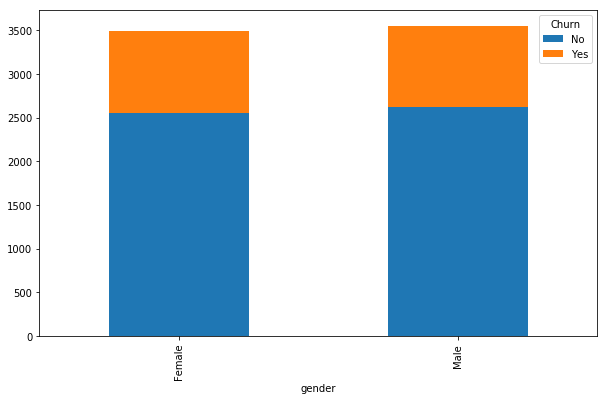

In [10]:
groupby_plot("gender","Churn")

Groupby Partner
Partner Counter({'No': 3641, 'Yes': 3402})


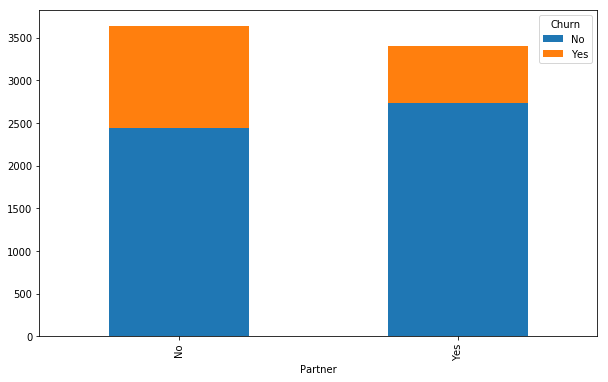

In [11]:
#partner

groupby_plot("Partner","Churn")

Groupby Dependents
Dependents Counter({'No': 4933, 'Yes': 2110})


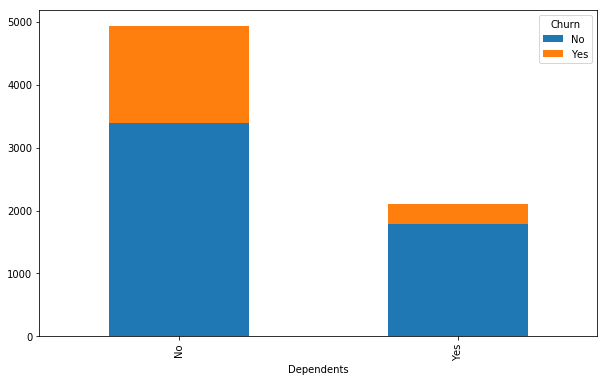

In [12]:
# Depedndents

groupby_plot("Dependents","Churn")



Customers that have no dependents are more likely to churn than customers that have dependents. Interesting.


Groupby PhoneService
PhoneService Counter({'Yes': 6361, 'No': 682})


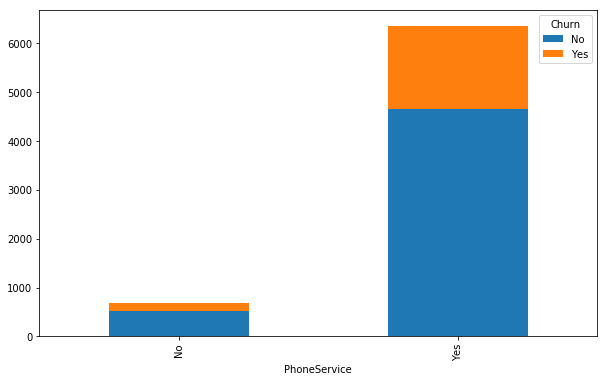

In [13]:
#PhoneService

groupby_plot("PhoneService","Churn")


There are not many customers did not sign up for phone service, whether customer have phone service or not does not seem to have an effect on the churn.

Groupby MultipleLines
MultipleLines Counter({'No': 3390, 'Yes': 2971, 'No phone service': 682})


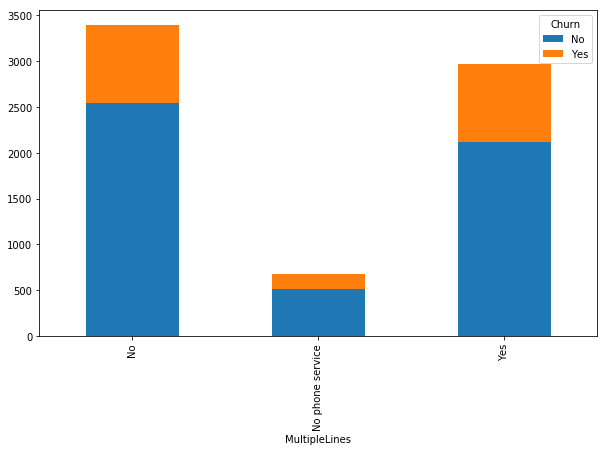

In [14]:
#MultipleLines

groupby_plot("MultipleLines","Churn")

Whether customer signed up for MultipleLines or not does not seem to have an effect on the churn.

Groupby InternetService
InternetService Counter({'Fiber optic': 3096, 'DSL': 2421, 'No': 1526})


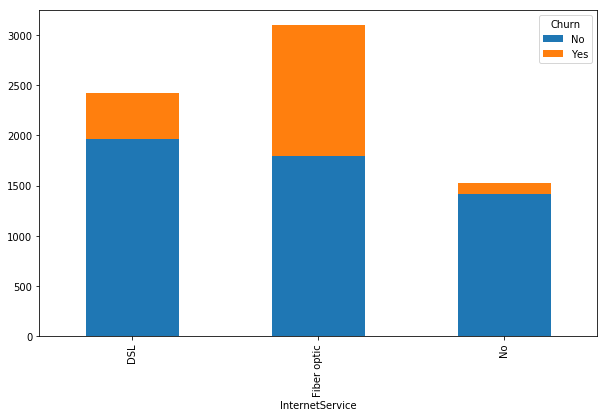

In [15]:

#internetservice

groupby_plot("InternetService","Churn")

It seems customers who signed up for Fiber optic are most likely to churn, almost 50% of them churned.

Groupby OnlineSecurity
OnlineSecurity Counter({'No': 3498, 'Yes': 2019, 'No internet service': 1526})


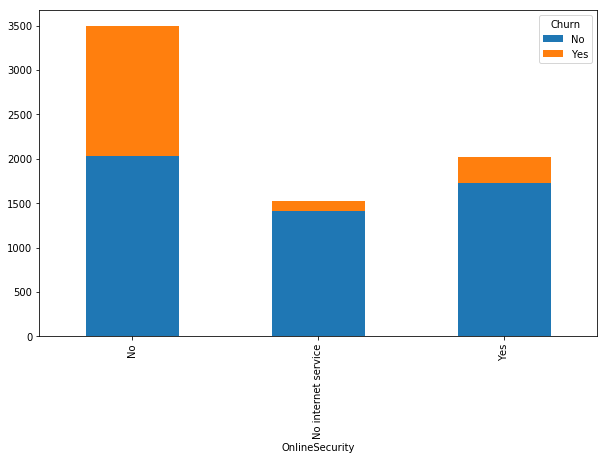

In [16]:
#onilne security
groupby_plot("OnlineSecurity","Churn")

Customers who did not sign up for OnlineSecurity are most likely to churn.

Groupby OnlineBackup
OnlineBackup Counter({'No': 3088, 'Yes': 2429, 'No internet service': 1526})


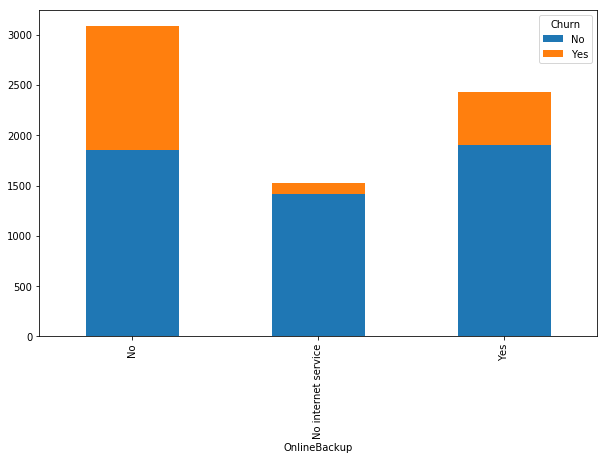

In [17]:
#OnlineBackup

groupby_plot("OnlineBackup","Churn")

Customers who did not sign up for OnlineBackUp are most likely to churn.

Groupby DeviceProtection
DeviceProtection Counter({'No': 3095, 'Yes': 2422, 'No internet service': 1526})


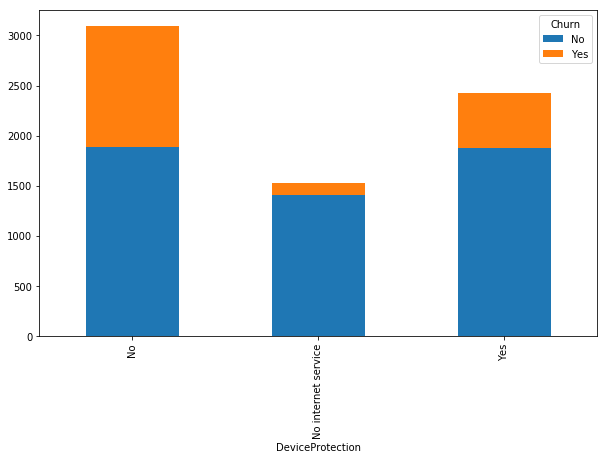

In [18]:
#DeviceProtection
groupby_plot("DeviceProtection","Churn")

Customers who did not sign up for DeviceProtection are most likely to churn.

Groupby TechSupport
TechSupport Counter({'No': 3473, 'Yes': 2044, 'No internet service': 1526})


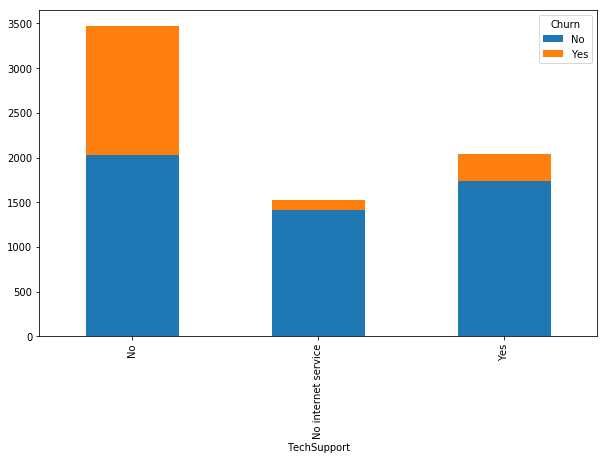

In [19]:
#TechSupport
groupby_plot("TechSupport","Churn")

Customers who did not sign up for TechSupport are most likely to churn.

Groupby StreamingTV
StreamingTV Counter({'No': 2810, 'Yes': 2707, 'No internet service': 1526})


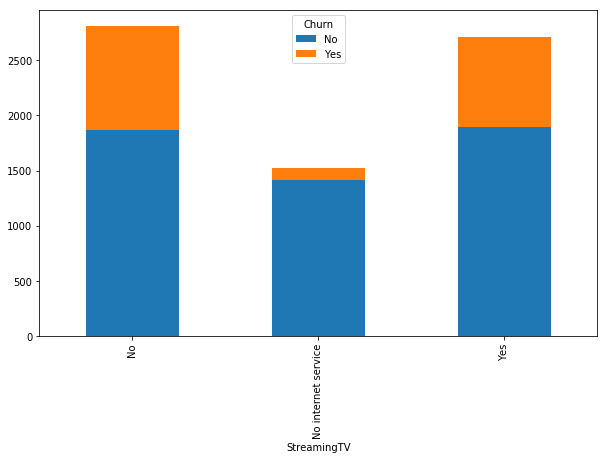

In [20]:
#StreamingTV
groupby_plot("StreamingTV","Churn")

Groupby StreamingMovies
StreamingMovies Counter({'No': 2785, 'Yes': 2732, 'No internet service': 1526})


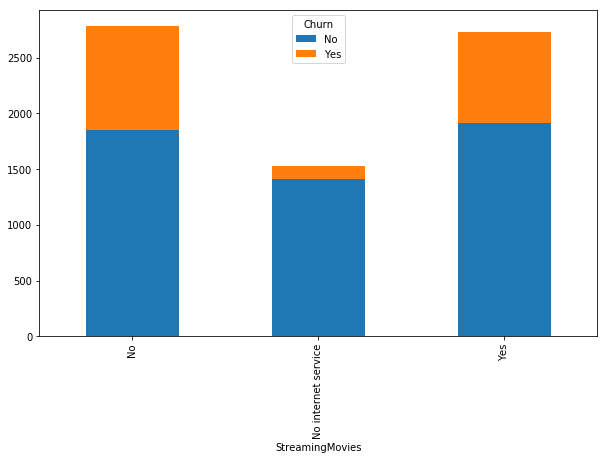

In [21]:
#steaming movies
groupby_plot("StreamingMovies","Churn")

From above seven plots, we can see that customers without internet service have a very low churn rate.

Groupby Contract
Contract Counter({'Month-to-month': 3875, 'Two year': 1695, 'One year': 1473})


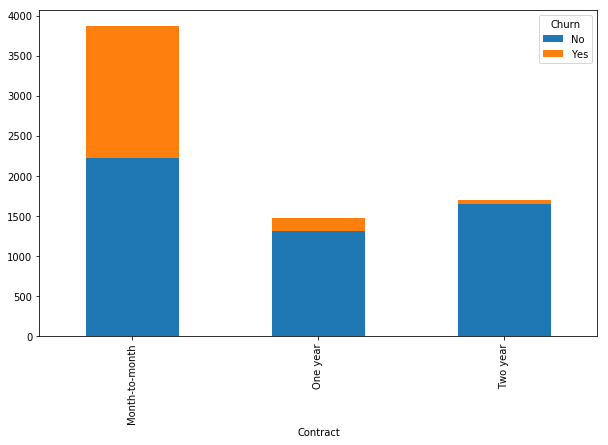

In [22]:
#Contract

groupby_plot("Contract","Churn")

It is obvious that contract term does have an effect on churn. There were very few churns when customers have a two-year contract. And most churns occurred on customers with a month-to-month contract.

Groupby PaperlessBilling
PaperlessBilling Counter({'Yes': 4171, 'No': 2872})


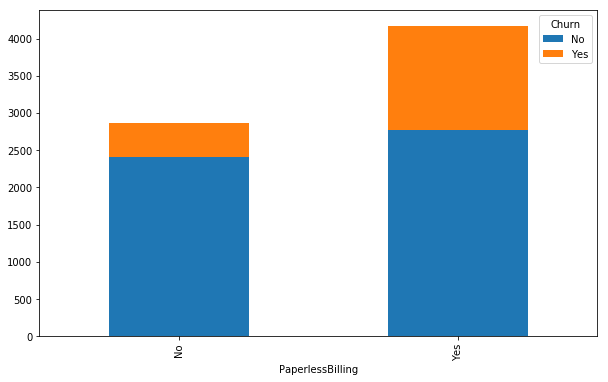

In [23]:
#paperless billling
groupby_plot("PaperlessBilling","Churn")

Groupby PaymentMethod
PaymentMethod Counter({'Electronic check': 2365, 'Mailed check': 1612, 'Bank transfer (automatic)': 1544, 'Credit card (automatic)': 1522})


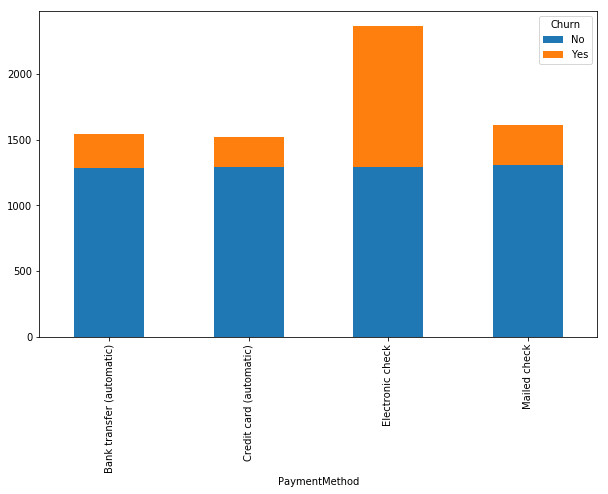

In [24]:
#payement method
groupby_plot("PaymentMethod","Churn")

PaymentMethod does seem to have an effect on churn, in particular, pay by electronic check has the highest percentage churning rate.

Groupby SeniorCitizen
SeniorCitizen Counter({0: 5901, 1: 1142})


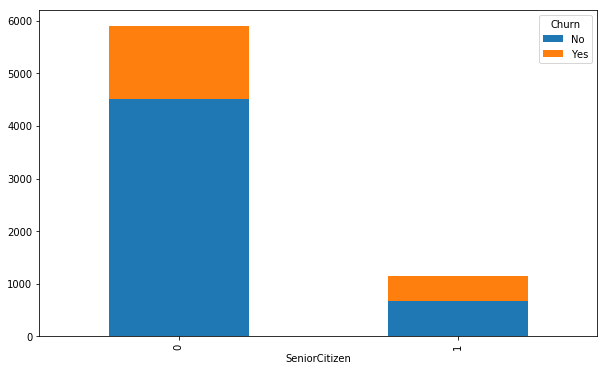

In [25]:
#seniorcitizen
groupby_plot("SeniorCitizen","Churn")

We do not have many senior citizens in the data. It seems whether customers are seniors citizens or not does not have an effect on the churning rate.

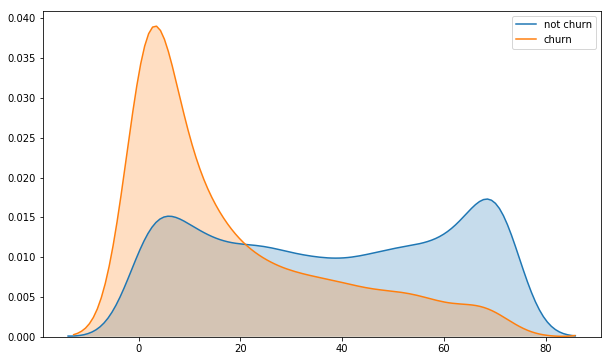

In [26]:


sns.kdeplot(data['tenure'].loc[data['Churn'] == 'No'], label='not churn', shade=True);
sns.kdeplot(data['tenure'].loc[data['Churn'] == 'Yes'], label='churn', shade=True);



In [27]:
data['tenure'].loc[data['Churn'] == 'No'].describe()

count    5174.000000
mean       37.569965
std        24.113777
min         0.000000
25%        15.000000
50%        38.000000
75%        61.000000
max        72.000000
Name: tenure, dtype: float64

In [28]:
data['tenure'].loc[data['Churn'] == 'Yes'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: tenure, dtype: float64

Not churned customers have a much longer average tenure (20 months) than the churned customers.

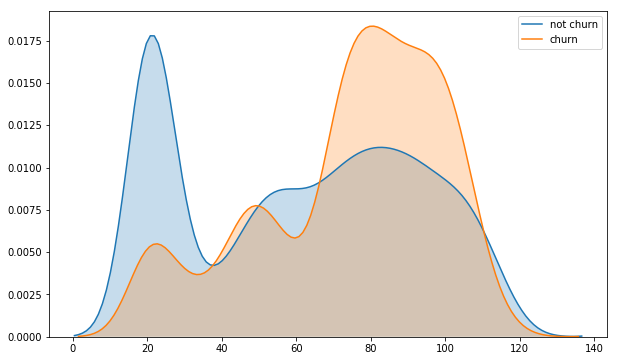

In [29]:
sns.kdeplot(data['MonthlyCharges'].loc[data['Churn'] == 'No'], label='not churn', shade=True);
sns.kdeplot(data['MonthlyCharges'].loc[data['Churn'] == 'Yes'], label='churn', shade=True);

In [30]:
data['MonthlyCharges'].loc[data['Churn'] == 'No'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [31]:
data['MonthlyCharges'].loc[data['Churn'] == 'Yes'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

Churned customers paid over 20% higher on average monthly fee than not-churned customers.

In [0]:
le = preprocessing.LabelEncoder()
data['Churn'] = le.fit_transform(data.Churn.values)

In [0]:
data = data.fillna(data.mean())

In [0]:
#encode Categorical features
categorical=['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for feature in categorical:
  dummies=pd.get_dummies(data[feature], prefix=feature,prefix_sep="_")
  data=pd.concat([data,dummies],axis=1)
data.drop(categorical,axis=1,inplace=True)

In [35]:
data.shape

(7043, 47)

In [36]:
#splitting the data into trian and test sets

X_train, X_val = train_test_split(data, test_size=2958)

cols = [c for c in data.columns if c not in ['customerID','Churn']]
y_train = X_train['Churn'].as_matrix()
X_train = MinMaxScaler().fit_transform(X_train[cols])
y_val= X_val['Churn'].as_matrix()
X_val = MinMaxScaler().fit_transform(X_val[cols])

print(y_train.shape, y_val.shape)

(4085,) (2958,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=1479, random_state=0)
print(y_train.shape, y_val.shape, y_test.shape, data.shape)


(4085,) (1479,) (1479,) (7043, 47)


In [38]:
def fit_batchsize(X,y,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    X = X[0:n_size]
    y = y[0:n_size]
    return X, y

batch_size = 100

X_train, y_train = fit_batchsize(X_train,y_train, batch_size)
X_val, y_val = fit_batchsize(X_val, y_val, batch_size)

X_test,y_test = fit_batchsize(X_test,y_test, batch_size)
print(X_val.shape, X_train.shape)

(1400, 45) (4000, 45)


In [39]:
# Define input layer
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))
# Define Encoder layers
n_z = 2
n_epoch = 200

h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z, name='sampleZ', output_shape=(n_z,))([mu, log_sigma])

# Define decoder layers in VAE model
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(input_dim, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:


# translate our loss into Keras code
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl



In [41]:
vae.compile(optimizer='adam', loss=vae_loss)
vae_history = vae.fit(X_train, X_train, batch_size=batch_size, shuffle=True, 
                      validation_data = (X_val, X_val),
                    epochs=n_epoch, callbacks = [EarlyStopping(monitor='loss',patience = 3)])

Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1400 samples
Epoch 1/200
4000/4000 [==============================] - 0s 121us/step - loss: 275.2966 - val_loss: 200.0373
Epoch 2/200
4000/4000 [==============================] - 0s 48us/step - loss: 175.3906 - val_loss: 160.3806
Epoch 3/200
4000/4000 [==============================] - 0s 50us/step - loss: 152.5551 - val_loss: 146.5334
Epoch 4/200
4000/4000 [==============================] - 0s 50us/step - loss: 139.9408 - val_loss: 137.1359
Epoch 5/200
4000/4000 [==============================] - 0s 49us/step - loss: 133.4587 - val_loss: 131.7849
Epoch 6/200
4000/4000 [==============================] - 0s 48us/step - loss: 129.0718 - val_loss: 128.4423
Epoch 7/200
4000/4000 [==============================] - 0s 47us/step - loss: 126.1830 - val_loss: 126.1272
Epoch 8/200
4000/4000 [==============================] - 0s 49us/step - loss: 124.1699 - val_loss: 124.5085
Epoch 9/200
4000/4000 [================

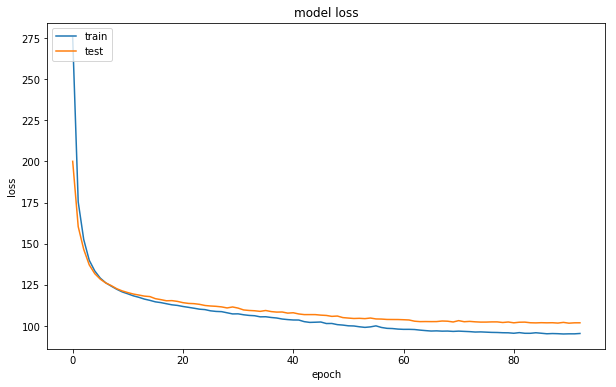

In [42]:


plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();




We use reconstruction error to measure how well the decoder is performing. Autoencoders are trained to reduce reconstruction error which we show below:


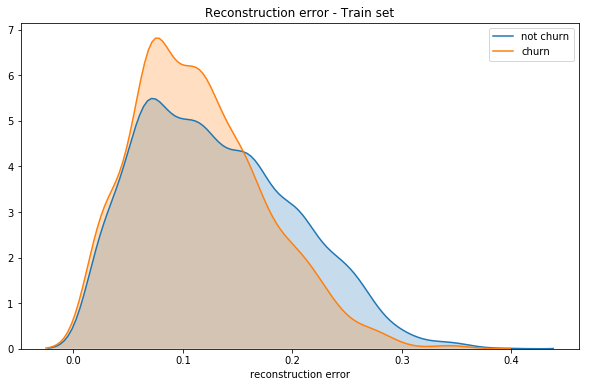

In [43]:


x_train_encoded = encoder.predict(X_train)

pred_train = decoder.predict(x_train_encoded)
mse = np.mean(np.power(X_train - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse,
                        'churn': y_train})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.title('Reconstruction error - Train set');



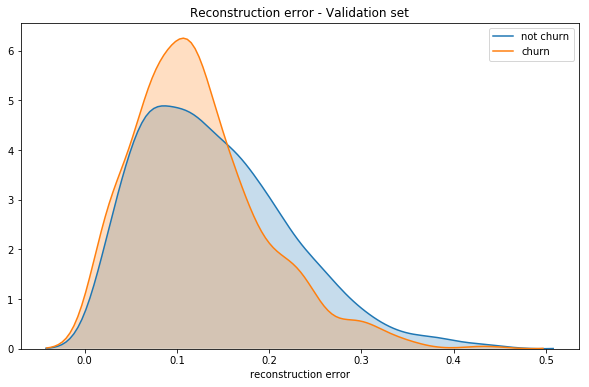

In [44]:
x_val_encoded = encoder.predict(X_val)

pred = decoder.predict(x_val_encoded)
mseV = np.mean(np.power(X_val - pred, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mseV,
                        'churn': y_val})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.title('Reconstruction error - Validation set');

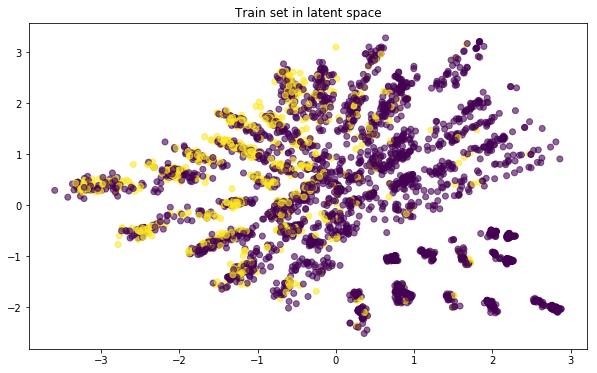

In [45]:
x_train_encoded = encoder.predict(X_train)

plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], 
            c=y_train, alpha=0.6)
plt.title('Train set in latent space')
plt.show();

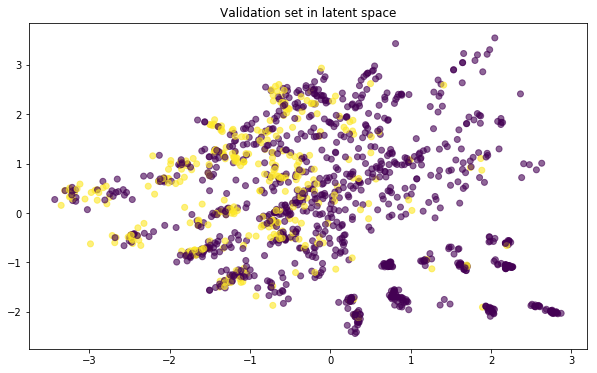

In [46]:
x_val_encoded = encoder.predict(X_val)

plt.scatter(x_val_encoded[:, 0], x_val_encoded[:, 1], 
            c=y_val, alpha=0.6)

plt.title('Validation set in latent space')
plt.show();

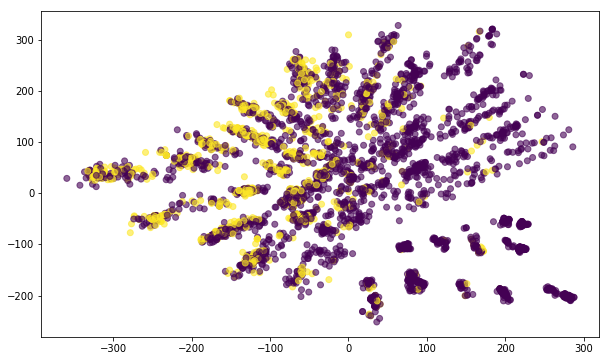

In [47]:
x_train_encoded = encoder.predict(X_train)
plt.scatter(100.*x_train_encoded[:, 0], 100.*x_train_encoded[:, 1], 
            c=y_train, alpha=0.6)
plt.show();


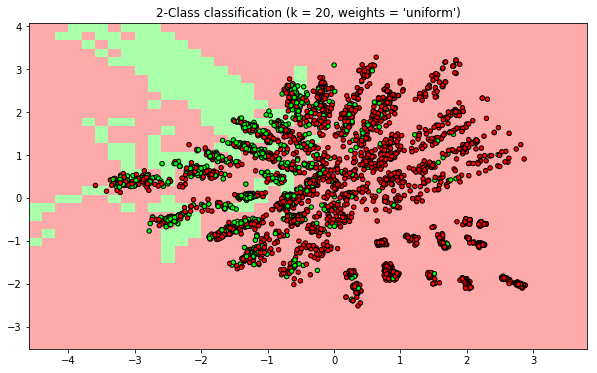

In [48]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
weights='uniform'
n_neighbors=20
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
X=x_train_encoded
y=y_train
clf.fit(X, y)

h=0.2
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i, weights = '%s')"% (n_neighbors, weights));

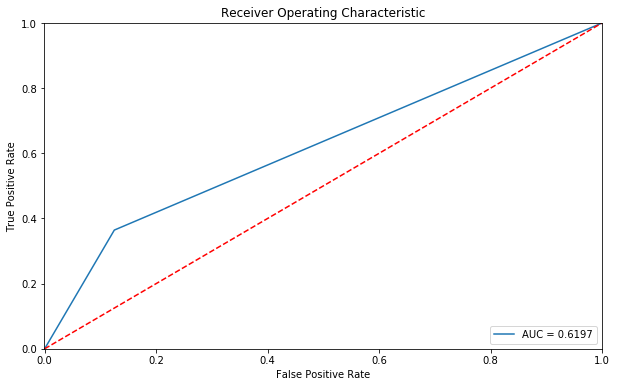

In [49]:


x_val_encoded = encoder.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, clf.predict(x_val_encoded))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();



In [50]:


print('Accuracy:')
print(accuracy_score(y_val, clf.predict(x_val_encoded)))
print("Confusion Matrix:")
print(confusion_matrix(y_val,clf.predict(x_val_encoded)))
print("Classification Report:")
print(classification_report(y_val,clf.predict(x_val_encoded)))



Accuracy:
0.7378571428571429
Confusion Matrix:
[[896 128]
 [239 137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1024
           1       0.52      0.36      0.43       376

   micro avg       0.74      0.74      0.74      1400
   macro avg       0.65      0.62      0.63      1400
weighted avg       0.72      0.74      0.72      1400



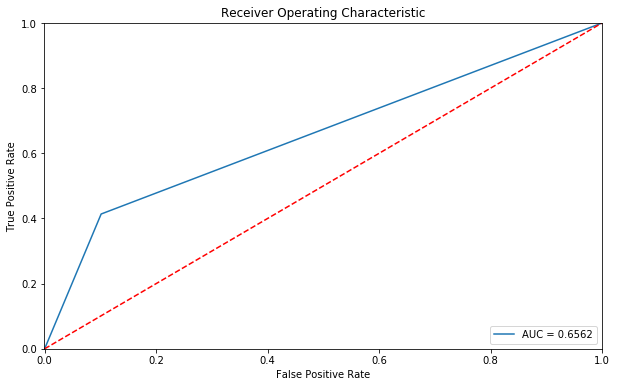

In [51]:


x_test_encoded = encoder.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(x_test_encoded))
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();



In [52]:
print('Accuracy:')
print(accuracy_score(y_test, clf.predict(x_test_encoded)))
print("Confusion Matrix:")
print(confusion_matrix(y_test,clf.predict(x_test_encoded)))
print("Classification Report:")
print(classification_report(y_test,clf.predict(x_test_encoded)))

Accuracy:
0.7621428571428571
Confusion Matrix:
[[904 102]
 [231 163]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1006
           1       0.62      0.41      0.49       394

   micro avg       0.76      0.76      0.76      1400
   macro avg       0.71      0.66      0.67      1400
weighted avg       0.75      0.76      0.75      1400

